In [50]:
import os
import glob
import numpy as np
import pandas as pd
import requests
import time
from datetime import datetime, date, time, timedelta
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

#for Data
import yfinance as yf

# for visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import plotly.graph_objects as go
import seaborn as sns


In [51]:
# Fetch historical data for the S&P 500
sp500_data = yf.download('^GSPC', start='2002-01-01', end='2024-01-01')

[*********************100%%**********************]  1 of 1 completed


In [52]:
print(sp500_data.head())
print(len(sp500_data)) # Print the first few rows of the data

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2002-01-02  1148.079956  1154.670044  1136.229980  1154.670044  1154.670044   
2002-01-03  1154.670044  1165.270020  1154.010010  1165.270020  1165.270020   
2002-01-04  1165.270020  1176.550049  1163.420044  1172.510010  1172.510010   
2002-01-07  1172.510010  1176.969971  1163.550049  1164.890015  1164.890015   
2002-01-08  1164.890015  1167.599976  1157.459961  1160.709961  1160.709961   

                Volume  
Date                    
2002-01-02  1171000000  
2002-01-03  1398900000  
2002-01-04  1513000000  
2002-01-07  1308300000  
2002-01-08  1258800000  
5537


In [77]:
#Simple Moving Average:
#returns the dataframe with additional coumn of simple moving average
def calculate_sma(df: pd.DataFrame, column: str = 'Adj Close', window_size: int = 15) -> pd.DataFrame:
    """
    Calculate the Simple Moving Average (SMA) for a given column in a DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing the financial data.
        column (str): Name of the column for which to calculate SMA. Default is 'close'.
        window_size (int): Size of the moving window. Default is 15.

    Returns:
        pd.DataFrame: DataFrame with SMA column added.
    """
    # Calculate SMA
    sma = df[column].rolling(window=window_size, min_periods=1).mean()
    
    # Create a DataFrame to store SMA
    df['SMA'] = sma
    df['SMA_signal'] = df['Close'] - df['SMA']
    return df

In [80]:
#Weighted Moving Average
def calculate_wma(df: pd.DataFrame, column: str = 'Adj Close', window_size: int = 15) -> pd.DataFrame:
    """
    Calculate the Weighted Moving Average (WMA) for a given column in a DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing the financial data.
        column (str): Name of the column for which to calculate WMA. Default is 'close'.
        window_size (int): Size of the moving window. Default is 15.

    Returns:
        pd.DataFrame: DataFrame with WMA and WMA signal columns added.
    """
    # Generate the weights
    weights = np.arange(1, window_size + 1)
    data = df[column]
    
    # Calculate the WMA using convolution
    wma = data.rolling(window=window_size).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
    
    # Create a DataFrame to store WMA
    df['WMA'] = wma
    
    # Add WMA signal column
    df['WMA_signal'] = df[column] - wma

    
    return df

In [203]:
#MACD
def calculate_macd(df: pd.DataFrame, short_window:int=12, long_window:int=26, signal_window:int=9, column: str = 'Adj Close') -> pd.DataFrame:
    """
    Calculate the Moving Average Convergence Divergence (MACD) for a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        short_window (int): The short-term window size for the short EMA.
        long_window (int): The long-term window size for the long EMA.
        signal_window (int): The window size for the signal line EMA.

    Returns:
        DataFrame: DataFrame with additional columns for MACD and signal line.
    """
    # Calculate short-term EMA
    short_ema = df[column].ewm(span=short_window, min_periods=1, adjust=False).mean()
    
    # Calculate long-term EMA
    long_ema = df[column].ewm(span=long_window, min_periods=1, adjust=False).mean()
    
    # Calculate MACD line
    macd_line = short_ema - long_ema
    
    # Calculate signal line
    signal_line = macd_line.ewm(span=signal_window, min_periods=1, adjust=False).mean()
    
    # Store MACD and signal line in the DataFrame
    df['MACD'] = macd_line
    df['Signal Line'] = signal_line
    df['macd_signal'] = macd_line - signal_line
    return df

In [204]:
#Stochastic_oscillator
def calculate_stochastic_oscillator(df, k_fast_period=14, k_slow_period=3, d_slow_period=3, column: str = 'Adj Close'):
    """
    Calculate the Stochastic Oscillator and its corresponding moving averages (K and D lines).

    Parameters:
        df (DataFrame): DataFrame containing the data.
        k_fast_period (int): The period for the fast %K line.
        k_slow_period (int): The period for the slow %K line.
        d_slow_period (int): The period for the slow %D line.

    Returns:
        DataFrame: DataFrame with additional columns for %K_fast, %K_slow, %D_fast, and %D_slow.
    """
    # Calculate highest high and lowest low over the period
    HH = df['High'].rolling(window=k_fast_period).max()
    LL = df['Low'].rolling(window=k_fast_period).min()

    # Calculate %K_fast
    df['%K_fast'] = ((df[column] - LL) / 
                     (HH - LL)) * 100
    
    # Calculate %K_slow (smoothed %K_fast)
    df['%K_slow'] = df['%K_fast'].rolling(window=k_slow_period).mean()
    
    # Calculate %D_fast (3-day SMA of %K_slow)
    df['%D_fast'] = df['%K_slow'].rolling(window=d_slow_period).mean()
    
    # Calculate %D_slow (3-day SMA of %D_fast)
    df['%D_slow'] = df['%D_fast'].rolling(window=d_slow_period).mean()
    
    return df

In [205]:
#RSI
def calculate_rsi(df, window_size=14, column: str = 'Adj Close'):
    """
    Calculate the Relative Strength Index (RSI) for a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        window (int): The window size for calculating RSI.

    Returns:
        DataFrame: DataFrame with an additional column for RSI.
    """
    # Calculate price changes
    delta = df[column].diff()
    
    # Define up and down moves
    gain = (delta.where(delta > 0, 0)).rolling(window=window_size).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window_size).mean()
    
    # Calculate the relative strength (RS)
    rs = gain / loss
    
    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))
    
    # Store RSI in the DataFrame
    df['RSI'] = rsi
    
    return df

In [206]:
#WPR
def calculate_williams_percent_r(df, window=14, column: str = 'Adj Close'):
    """
    Calculate the Williams %R (WPR) for a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        window (int): The window size for calculating WPR.

    Returns:
        DataFrame: DataFrame with an additional column for WPR.
    """
    # Calculate highest high and lowest low over the window
    highest_high = df['High'].rolling(window=window).max()
    lowest_low = df['Low'].rolling(window=window).min()
    
    # Calculate Williams %R
    wpr = ((highest_high - df[column]) / (highest_high - lowest_low)) * -100
    
    # Store WPR in the DataFrame
    df['WPR'] = wpr
    
    return df

In [207]:
#Bollinger Bands
def calculate_bollinger_bands(df, window=20, num_std_dev=2, column: str = 'Adj Close'):
    """
    Calculate Bollinger Bands for a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        window (int): The window size for the moving average.
        num_std_dev (int): The number of standard deviations for the bands.

    Returns:
        DataFrame: DataFrame with additional columns for Bollinger Bands.
    """
    # Calculate rolling mean and standard deviation
    rolling_mean = df[column].rolling(window=window).mean()
    rolling_std = df[column].rolling(window=window).std()
    
    # Calculate upper and lower bands
    upper_band = rolling_mean + (rolling_std * num_std_dev)
    lower_band = rolling_mean - (rolling_std * num_std_dev)
    
    # Store Bollinger Bands in the DataFrame
    df['Bollinger Upper'] = upper_band
    df['Bollinger Lower'] = lower_band
    df['Bollinger Diff'] = upper_band - lower_band
    
    return df

In [208]:
#On-Balance Volume (OBV)
def calculate_obv(df, column: str = 'Adj Close'):
    """
    Calculate On-Balance Volume (OBV) for a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.

    Returns:
        DataFrame: DataFrame with additional column for OBV.
    """
    obv_values = []
    prev_obv = 0

    for i in range(1, len(df)):
        if df[column].iloc[i] > df[column].iloc[i - 1]:
            obv = prev_obv + df['Volume'].iloc[i]
        elif df[column].iloc[i] < df[column].iloc[i - 1]:
            obv = prev_obv - df['Volume'].iloc[i]
        else:
            obv = prev_obv

        obv_values.append(obv)
        prev_obv = obv

    # Add initial OBV value as 0
    obv_values = [0] + obv_values

    # Store OBV in the DataFrame
    df['OBV'] = obv_values

    return df

In [209]:
#Bulid the technical indicators: features
def technical_indicators(df):
    df = calculate_sma(df)
    df = calculate_wma(df)
    df = calculate_macd(df)
    df = calculate_rsi(df)
    df = calculate_stochastic_oscillator(df)
    df = calculate_bollinger_bands(df)
    df = calculate_williams_percent_r(df)
    df = calculate_obv(df)

    return df  

In [210]:
# All analyzed technical indicators are lagged by one period before being used as predictors for returns in the models in order to avoid the so-called look ahead 
# bias involving making decisions in the same period for which the given signal was generated.
def lag_technical_indicators(df):
    """
    Lag all columns in a DataFrame by one period.

    Parameters:
        df (DataFrame): DataFrame containing the calculated technical indicators.

    Returns:
        DataFrame: DataFrame with all columns lagged by one period.
    """
    # Lag all columns by one period
    df_lagged = df.shift()
    
    return df_lagged

In [211]:
# Transformation Function
# Technical analysis indicators need to be rescaled before being fed to the models.
# The process is conducted using a version of min-max normalization technique which produces outputs in range from ‐1 to 1.
# This technique was chosen for two reasons: it is intuitive as the machine learning models produce output 
# variable that is also ranging from ‐1 to 1 and because it causes the input data to be more comparable. 
# X'(t) = (X(t) - min(x)) / (max(x) - min(x))*2 -1

def feature_transform(df):
    """
    Transform all columns in the DataFrame as the following formula
    X'(t) = (X(t) - min(x)) / (max(x) - min(x))*2 -1

    Parameters:
        df (DataFrame): DataFrame containing the calculated technical indicators.

    Returns:
        DataFrame: DataFrame with all columns transformed.
    """
    max_x = df.max()
    min_x = df.min()

    df_transformed = (df - min_x) / (max_x - min_x) * 2 - 1

    return df_transformed

In [212]:
#df['discrete_return'] = (df['CLOSE'] - df['CLOSE'].shift(1)) / df['CLOSE'].shift(1)
#df['discrete_return'] = np.log(df['CLOSE']/df['CLOSE'].shift(1)) # opposed to closing prices, to avoid look-ahead bias.

#Log_return:
def calculate_log_return(df, column='Adj Close'):
    """
    Calculate log returns from adjusted close prices.

    Parameters:
        df (DataFrame): DataFrame containing adjusted close prices.
        column (str): Name of the column containing adjusted close prices.

    Returns:
        DataFrame: DataFrame containing log returns.
    """
    # Shift adjusted close prices by one day to get t-1 prices
    previous_adj_close = df[column].shift(1)
    
    # Calculate log returns
    log_returns = np.log(df[column] / previous_adj_close)
    # Concatenate log returns with the original DataFrame
    df['log_return'] = log_returns  
    
    return df

In [213]:
def calculate_log_returns_per(df, column='Adj Close'):
    """
    Calculate logarithmic returns for adjusted closing prices.
    
    Parameters:
        df (DataFrame): DataFrame containing adjusted closing prices.
        column_name (str): Name of the column containing adjusted closing prices.
        
    Returns:
        log_returns (Series): Series containing logarithmic returns.
    """
    # Calculate the percentage change in adjusted closing prices
    returns = df[column].pct_change()
    
    # Calculate logarithmic returns
    log_returns = np.log(1 + returns)
    df['log_return_per'] = log_returns  

    return df

In [214]:
def calculate_discrete_returns(df, column='Adj Close'):
    """
    Calculate discrete returns for a given column in a DataFrame.
    
    Parameters:
        df (DataFrame): DataFrame containing the data.
        column_name (str): Name of the column for which to calculate discrete returns.
        
    Returns:
        discrete_returns (Series): Series containing discrete returns.
    """
    # Calculate the difference between consecutive values
    differences = df[column].diff()
    
    # Calculate discrete returns
    discrete_returns = differences / df[column].shift(1)
    df['discrete_return'] = discrete_returns  
    
    return df

In [215]:
#truncate the dataframe from the biggining so the walk forward splits will continue untill the last date
def truncate_before_wf(df, in_sample_size, out_sample_size):
    drop_index = (len(df) - in_sample_size) % out_sample_size
    return (df.iloc[drop_index:, :])

In [325]:
# Research employed dynamic estimation windows which means that the underlying parameters of the models 
# were periodically recalibrated to reflect current market behaviors. Observations from the beginning 
# of the available period were initially trimmed in order for the overall number of observations for
# each index to be easily divisible into equal subsets. Calibration of models’ parameters was conducted 
# on 200 trading day window (in-sample) and then model predictions were applied onto next 20 trading day
# window (out-of-sample). For each subsequent dynamic window iteration, in-sample and out-of-sample moved 
# by 20 trading days. 

def walk_forward_validation(df, in_sample_size, out_sample_size):
    """
    Perform walk-forward validation on a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        in_sample_size (int): Number of periods to use for in-sample data.
        out_sample_size (int): Number of periods to use for out-of-sample data.

    Returns:
        Tuple: Tuple containing lists of in-sample and out-of-sample data.
    """
    total_rows = len(df)
    n_subsets = (total_rows - in_sample_size) // out_sample_size
    splits = []
        
    for i in range(n_subsets):
        start_index = i * out_sample_size
        end_index = start_index + in_sample_size + out_sample_size
        
        if end_index > total_rows:
            break
        
        in_sample = df.iloc[start_index : start_index + in_sample_size]
        out_of_sample = df.iloc[start_index + in_sample_size : end_index]
        
        splits.append((in_sample, out_of_sample))
    return (splits)

In [281]:
# Compute the correlation coefficients between each feature and the return & print it

def correlation(df, target_name):

    correlation_with_target = np.abs(df.corrwith(df[target_name]))

    # Display the correlation coefficients
    print("Correlation with Log return:")
    print(correlation_with_target.sort_values(ascending=False))
    correlation_with_target.sort_values().plot.barh(color = 'blue',title = 'Strength of Correlation', )

In [282]:
#Thus far, we've only used a simple correlation statistic across the full time period. 
#This is a good place to start but, is a dangerous place to stop. Financial time series data suffers
# from non-stationarity and regime change, so a relationship which on average has existed may have been 
#wildly unstable over time.

#To check, we'll plot the rolling correlation of these selected features.

# Compute the rolling correlation for each pair of selected features
def rolling_correlation(df, target_name, window_size = 200):

    correlation_with_target_200 = df.rolling(window=window_size).corr(df[target_name])
    # Create traces for each feature
    traces = []
    for feature in df.columns:
        trace = go.Scatter(
            x=correlation_with_target_200.index,
            y=correlation_with_target_200[feature],
            mode='lines',
            name=feature
        )
        traces.append(trace)

    # Create layout for the plot
        layout = go.Layout(
        title='Rolling Correlation of Features with Log Return',
        xaxis=dict(title='Index'),
        yaxis=dict(title='Rolling Correlation with Log Return'),
        hovermode='closest',
        autosize=True
    )

    # Create figure object
    fig = go.Figure(data=traces, layout=layout)

    # Show plot
    fig.show()

In [283]:
def features_paiplot(df):
    pairplot = sns.pairplot(df, height=1.5)

    # Set the title
    pairplot.figure.suptitle('Pairplot of features', y=1.02)

    # Show the plot
    plt.show()

In [220]:
#Truncate NaN Data
def drop_NAN(df):
    # Remove rows with NaN values
    cleaned_df = df.dropna()

    return cleaned_df

In [67]:
## start from here

In [400]:
#try 
sp500 = sp500_data.copy()
sp500 = technical_indicators(sp500)

In [401]:
#laging technical indicators to avoid look_ahead bias
sp500.iloc[:, 5:] = sp500.iloc[:, 5:].apply(lag_technical_indicators, axis=0)

C:\Users\Nagham\AppData\Local\Temp\ipykernel_16356\3964245760.py:2: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Date
2002-01-02             NaN
2002-01-03    1.171000e+09
2002-01-04    1.398900e+09
2002-01-07    1.513000e+09
2002-01-08    1.308300e+09
                  ...     
2023-12-22    3.431180e+09
2023-12-26    3.046770e+09
2023-12-27    2.513910e+09
2023-12-28    2.748450e+09
2023-12-29    2.698860e+09
Name: Volume, Length: 5537, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\Nagham\AppData\Local\Temp\ipykernel_16356\3964245760.py:2: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Date
2002-01-02             NaN
2002-01-03    0.000000e+00
2002-01-04    1.398900e+09
2002-01-07    2.911900e+09
2002-01-08    1.603600e+09
                  ...     
2023-12-22    1.284571e+1

In [402]:
#add the log returns:
sp500 = calculate_log_return(sp500)
sp500 = calculate_discrete_returns(sp500)
sp500 = calculate_log_returns_per(sp500)

In [403]:
#transform features
sp500.iloc[:, 6:22] = sp500.iloc[:, 6:22].apply(feature_transform, axis=0)

In [342]:
#correlation before choosing features
#correlation(sp500, 'log_return')
#rolling_correlation(sp500, 'log_return')

# Step 1: Take the most strongly correlated feature and add it to our list of selected features. 
# Step 2: Take the second correlated feature and check to see if it's closely correlated 
# (neighboring in the clustermap) to any features already chosen.
# If no, add to the list. If yes, discard. 
# Step 3: Repeat this process until either (1) we've reached the target feature count, or (2) we've run out strongly correlated features.

In [413]:
#clean the data from na values & pick the columns
sp500_d = sp500.copy()
sp500_d = drop_NAN(sp500_d)
sp500_d = sp500_d.loc[:, ['WMA_signal', 'macd_signal', 'RSI', '%K_fast', '%D_fast', '%D_slow', 'Bollinger Diff', 'WPR', 'OBV', 'log_return']]

In [405]:
#look at the correlated data:
#features_paiplot(sp500_d)
#correlation(sp500_d, 'log_return')
#rolling_correlation(sp500, 'log_return')


In [414]:
#choosing features:
chosen_features = ['WMA_signal', 'macd_signal', 'RSI', '%K_fast', '%D_fast', '%D_slow', 'Bollinger Diff', 'WPR', 'OBV']


In [415]:
#Model - Linear SVR
#Split the data
sp500_d = truncate_before_wf(sp500_d, 200, 20)
splits = walk_forward_validation(sp500_d, 200, 20)
Linear_SVR = SVR(C=1, kernel='linear')

In [416]:
#train the model

# Initialize an empty list to store predictions
sp500_d['Predections_LinearSVM'] = np.nan

#Iterate over list of C params in order to find the best parameter
numParams = 20 #<! Number of different values of `C`
lC = np.linspace(0.001, 10, numParams) #<! The list of `C` values to optimize over
dBestScore = {'Accuracy': 0, 'C': 0} #<! Dictionary to keep the highest score and the corresponding `C`
#train the model

# Initialize an empty list to store predictions
sp500_d['Predections_LinearSVM'] = np.nan

for ii, paramC in enumerate(lC):
    
    oSvrClassifier = SVR(C = paramC, kernel = 'linear') #<! Construct the SVC object
    #initiate the modelScore sum
    modelScore = 0

    # Loop through the splits and make predictions for each iteration
    for i, (in_sample, out_of_sample) in enumerate(splits):
        #Train the model on in_sample data
        X_train = in_sample.drop(columns=['log_return']) # dropping target variable
        y_train = in_sample['log_return']
        oSvrClassifier.fit(X_train,y_train)

        # Make predictions on the out-of-sample data
        X_test = out_of_sample.drop(columns=['log_return'])
        y_test = out_of_sample['log_return']
        predictions = oSvrClassifier.predict(X_test)
        
        # Out of Sample Index
        #oosI = out_of_sample.index # Adjusted index to match shifted returns

        #Add predictions to df
        #sp500_d.loc[oosI, 'Predections_LinearSVM']  = predictions
        modelScore     += oSvrClassifier.score(X_test, y_test) #<! Calculate the score (Accuracy)
    modelScore = modelScore/len(splits)
    print(modelScore)
    if (modelScore > dBestScore['Accuracy']):
        dBestScore['Accuracy'] = modelScore #<! Update the new best score
        dBestScore['C'] = paramC #<! Update the corresponding `C` hyper parameter

print(f'The best model has accuracy of {dBestScore["Accuracy"]:0.2%} with `C = {dBestScore["C"]}`')


-4.725258035108473
-4.725258035108473
-4.725258035108473
-4.725258035108473
-4.725258035108473
-4.725258035108473
-4.725258035108473
-4.725258035108473
-4.725258035108473
-4.725258035108473
-4.725258035108473
-4.725258035108473
-4.725258035108473
-4.725258035108473
-4.725258035108473
-4.725258035108473
-4.725258035108473
-4.725258035108473
-4.725258035108473
-4.725258035108473
The best model has accuracy of 0.00% with `C = 0`


In [419]:
# In the context of regression tasks like this one (since SVR is a Support Vector Machine for regression),
# where the target variable is continuous (e.g., log returns), a model score less than 0 typically indicates 
# that the model is performing poorly and making predictions that are worse than simply using the mean or another
# basic statistical measure as the prediction for all samples.

In [417]:
#train the model

# Initialize an empty list to store predictions
sp500_d['Predections_LinearSVM'] = np.nan


# Loop through the splits and make predictions for each iteration
for i, (in_sample, out_of_sample) in enumerate(splits):
    #Train the model on in_sample data
    X_train = in_sample.drop(columns=['log_return']) # dropping target variable
    y_train = in_sample['log_return']
    Linear_SVR.fit(X_train,y_train)

    # Make predictions on the out-of-sample data
    X_test = out_of_sample.drop(columns=['log_return'])
    predictions = Linear_SVR.predict(X_test)

    # Out of Sample Index
    oosI = out_of_sample.index # Adjusted index to match shifted returns

    #Add predictions to df
    sp500_d.loc[oosI, 'Predections_LinearSVM']  = predictions

In [418]:
sp500_d = drop_NAN(sp500_d)


In [368]:
sp500_d.head()

,WMA_signal,macd_signal,RSI,%K_fast,%D_fast,%D_slow,Bollinger Diff,WPR,OBV,log_return,Predections_LinearSVM
Date,,,,,,,,,,,
2002-12-10,0.304227,-0.068070,-0.093399,-0.999036,-0.374965,-0.095220,-0.905706,-0.999036,-3.466213e+10,0.013861,0.00666
2002-12-11,0.352406,-0.069451,0.016374,-0.599421,-0.553564,-0.352296,-0.917620,-0.599421,-3.337553e+10,0.000564,0.00666
2002-12-12,0.360064,-0.067367,-0.102905,-0.583051,-0.692428,-0.560219,-0.926688,-0.583051,-3.209043e+10,-0.003742,0.00666
2002-12-13,0.356215,-0.067127,-0.304416,-0.691541,-0.685679,-0.665424,-0.936533,-0.691541,-3.334573e+10,-0.013512,0.00666
2002-12-16,0.327612,-0.077011,-0.356104,-0.969605,-0.716460,-0.720579,-0.930361,-0.969605,-3.467653e+10,0.023247,0.00666


In [369]:
# Assuming df is your DataFrame containing the data
# Replace 'feature1' and 'feature2' with the names of the features you want to plot
feature1 = 'log_return'
feature2 = 'Predections_LinearSVM'

# Create line plot
fig = go.Figure(data=go.Scatter(
    x=sp500_d.index,  # Assuming the index represents x-axis values
    y=sp500_d[feature1],
    mode='lines',
    name=feature1
))

# Add another line plot for the second feature
fig.add_trace(go.Scatter(
    x=sp500_d.index,  # Assuming the index represents x-axis values
    y=sp500_d[feature2],
    mode='lines',
    name=feature2
))

# Customize layout
fig.update_layout(
    title='Linear SVR - log_return Vs. Predictions on train dataset - WF 200,20',
    xaxis=dict(title='X Axis'),  # Customize x-axis label
    yaxis=dict(title='Y Axis'),  # Customize y-axis label
    hovermode='closest'
)

# Show plot
fig.show()


In [370]:
#rasha code
#clean the data from na values & pick the columns
scaled_df = sp500.copy()
scaled_df = drop_NAN(scaled_df)
scaled_df = scaled_df.loc[:, ['WMA_signal', 'macd_signal', 'RSI', '%K_fast', '%D_fast', '%D_slow', 'Bollinger Diff', 'WPR', 'OBV', 'log_return']]

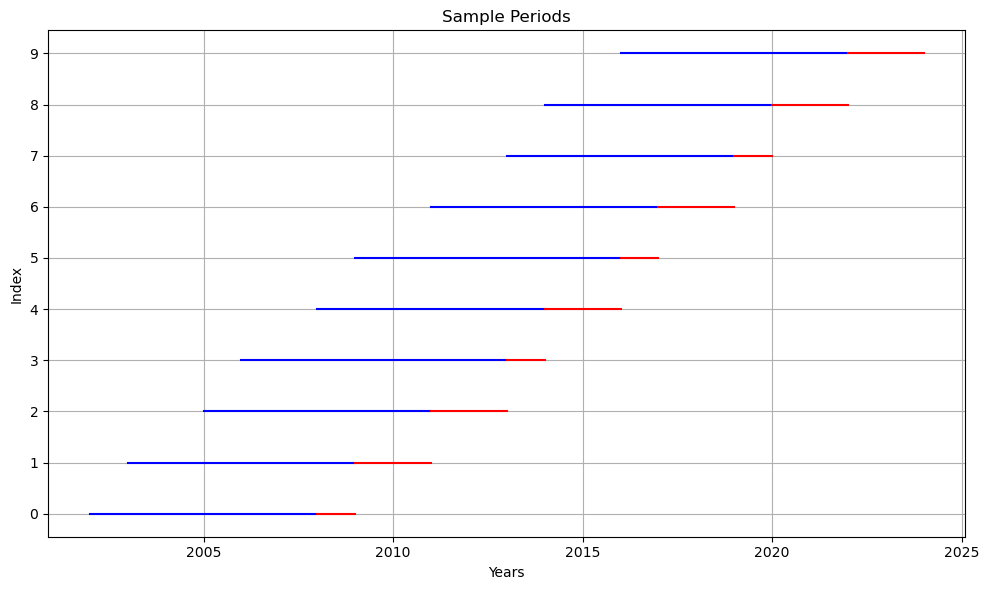

In [371]:
groups = 10
train = np.array(scaled_df)
X, y = train[:, :-1], train[:, -1]

def build_rolling_calendar(start_date, end_date, out_of_sample_size, runs, n_gap):
    days = (end_date - start_date).days

    in_sample_size = (100 - out_of_sample_size) / 100
    out_of_sample_size = out_of_sample_size / 100

    total_days_per_run = round(days / (runs * out_of_sample_size + in_sample_size))
    in_sample_days_per_run = round(total_days_per_run * in_sample_size)
    out_of_sample_days_per_run = round(total_days_per_run * out_of_sample_size)

    calendar = pd.DataFrame()

    calendar['InSampleStarts'] = [start_date + timedelta(days=(out_of_sample_days_per_run * x))
                                  for x in range(runs)]
    calendar['InSampleEnds'] = [x + timedelta(days=in_sample_days_per_run)
                                for x in calendar['InSampleStarts']]

    calendar['OutSampleStarts'] = [start_date + timedelta(days=in_sample_days_per_run + n_gap) +
                                   timedelta(days=(out_of_sample_days_per_run * x))
                                   for x in range(runs)]
    calendar['OutSampleEnds'] = [x + timedelta(days=out_of_sample_days_per_run)
                                 for x in calendar['OutSampleStarts']]

    return calendar


calendar = build_rolling_calendar(start_date=scaled_df.index.min(), end_date=scaled_df.index.max(), out_of_sample_size=20, runs=10, n_gap=20)


# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

for i, row in calendar.iterrows():
    ax.plot([row['InSampleStarts'].year, row['InSampleEnds'].year], [i, i], color='blue')
    ax.plot([row['OutSampleStarts'].year, row['OutSampleEnds'].year], [i, i], color='red')

# Customize plot
ax.set_yticks(calendar.index.values[::-1])
ax.set_yticklabels(calendar.index.values[::-1])
ax.set_xlabel('Years')
ax.set_ylabel('Index')
ax.set_title('Sample Periods')
ax.grid(True)

plt.tight_layout()
plt.show()

In [372]:
from itertools import chain

X_train = []
X_test = []
y_train = []
y_test = []
for i, row in calendar.iterrows():
    train = scaled_df.loc[row['InSampleStarts']: row['InSampleEnds']].to_numpy()
    X_train.append(train[:, :-1])
    y_train.append(train[:, -1])
    test = scaled_df.loc[row['OutSampleStarts']: row['OutSampleEnds']].to_numpy()
    X_test.append(test[:, :-1])
    y_test.append(test[:,-1])
    if i == 0: 
        X_train_signals = scaled_df.loc[row['OutSampleStarts']:].to_numpy()


flattened_y_test = np.array(list(chain(*y_test)))

In [381]:
svr_y_pred = []
svr = SVR(C=1, kernel='linear')
for i in range(len(X_train)):
    svr.fit(X_train[i], y_train[i])
    y_pred = svr.predict(X_test[i])
    svr_y_pred.extend(y_pred)
    #score = svr.score(y_pred, y_test[i])
    #print(f'batch {i} has a score of {score}')

# Assign the list of predictions to the DataFrame column
#sp500_d['Pred_log_return'].iloc[len((sp500_d)-200)] = np.concatenate(all_predictions)
#svr_score = svr.score(svr_y_pred,flattened_y_test)
#print(f'Accuracy of SVRegression is {svr_score}')


In [387]:
scaled_df['predictions'] = np.zeros(scaled_df.shape[0])

# Determine the index range for appending predictions
start_index = scaled_df.shape[0] - 3934
end_index = scaled_df.shape[0]

# Assign predictions to the last 3934 indices of the DataFrame column
scaled_df['predictions'].iloc[start_index:end_index] = svr_y_pred

#scaled_df['predictions'] = svr_y_pred

C:\Users\Nagham\AppData\Local\Temp\ipykernel_16356\75687010.py:8: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




In [388]:
scaled_df.head()

,WMA_signal,macd_signal,RSI,%K_fast,%D_fast,%D_slow,Bollinger Diff,WPR,OBV,log_return,predictions
Date,,,,,,,,,,,
2002-01-31,0.348314,-0.045964,-0.354627,-0.184620,-0.554774,-0.585866,-0.907893,-0.184620,-2.690000e+08,0.014824,0.0
2002-02-01,0.405828,-0.024413,-0.217141,0.248615,-0.493810,-0.555328,-0.908951,0.248615,1.288000e+09,-0.007104,0.0
2002-02-04,0.382644,-0.016735,-0.199933,0.207443,-0.251188,-0.451469,-0.913288,0.207443,-7.920000e+07,-0.025048,0.0
2002-02-05,0.303342,-0.038765,-0.307425,-0.619363,-0.089987,-0.294097,-0.910461,-0.619363,-1.516800e+09,-0.004047,0.0
2002-02-06,0.303483,-0.053770,-0.390146,-0.740896,-0.120292,-0.167627,-0.904818,-0.740896,-3.295100e+09,-0.005990,0.0


In [390]:
# Assuming df is your DataFrame containing the data
# Replace 'feature1' and 'feature2' with the names of the features you want to plot
feature1 = 'log_return'
feature2 = 'predictions'

# Create line plot
fig = go.Figure(data=go.Scatter(
    x=scaled_df.index,  # Assuming the index represents x-axis values
    y=scaled_df[feature1],
    mode='lines',
    name=feature1
))

# Add another line plot for the second feature
fig.add_trace(go.Scatter(
    x=scaled_df.index,  # Assuming the index represents x-axis values
    y=scaled_df[feature2],
    mode='lines',
    name=feature2
))

# Customize layout
fig.update_layout(
    title='Linear SVR - log_return Vs. Predictions on train dataset - WF 200,20',
    xaxis=dict(title='X Axis'),  # Customize x-axis label
    yaxis=dict(title='Y Axis'),  # Customize y-axis label
    hovermode='closest'
)

# Show plot
fig.show()
